In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# global imports
import os
import shutil
# torch imports
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [4]:
# global constant definitions
EPOCHS = 5
LR = 1e-4

In [5]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Task 1

 - Implement the (adapted) TriNet Siamese model and SimCLR:
    - ResNet convolutional backbone (until AvgPool) 
    - Fully connected frontend to obtain desired embedding
    - Normalization layer
 - Use *Labeled Faces in the Wild* (LFW) dataset (https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)
    - Over 13000 images
    - Train and test set
 - Train and Evaluate TriNet and SimCLR models
    - Try to find adequate temperature and margin values 
    - How do the models compare?
 - Evaluate and compare the model performance (need not be thorough)
 - Visualize embeddings (not necessary for all classes, e.g. pick the 10 classes with the most images)

### Dataset

In [6]:
# RUN once to save locally
# import kagglehub

# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

# SAVE_PATH = "./data"
# os.makedirs(SAVE_PATH, exist_ok=True)
# shutil.move(path, SAVE_PATH)

In [7]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

DATASET_PATH = "./data/4/lfw-deepfunneled/lfw-deepfunneled"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

lfw_dataset = ImageFolder(DATASET_PATH, transform=transform)

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

TEST_SPLIT = .2

indices = list(range(len(lfw_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT, random_state=42)

train_img_dataset = Subset(lfw_dataset, train_idx)
test_img_dataset = Subset(lfw_dataset, test_idx)

In [9]:
from dataset import TripletDataset

test_dataset = TripletDataset(test_img_dataset)
train_dataset = TripletDataset(train_img_dataset)

KeyboardInterrupt: 

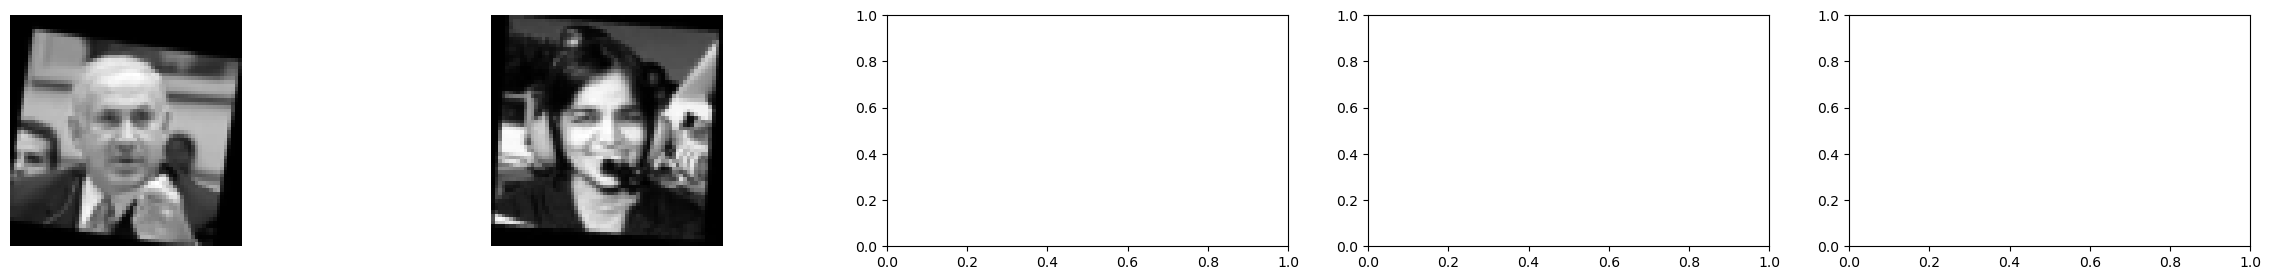

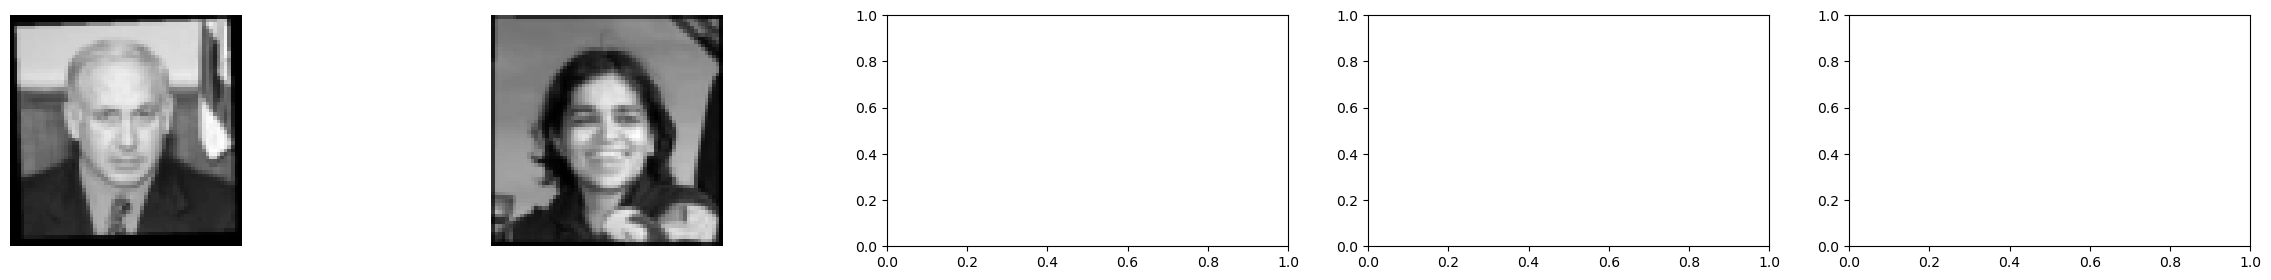

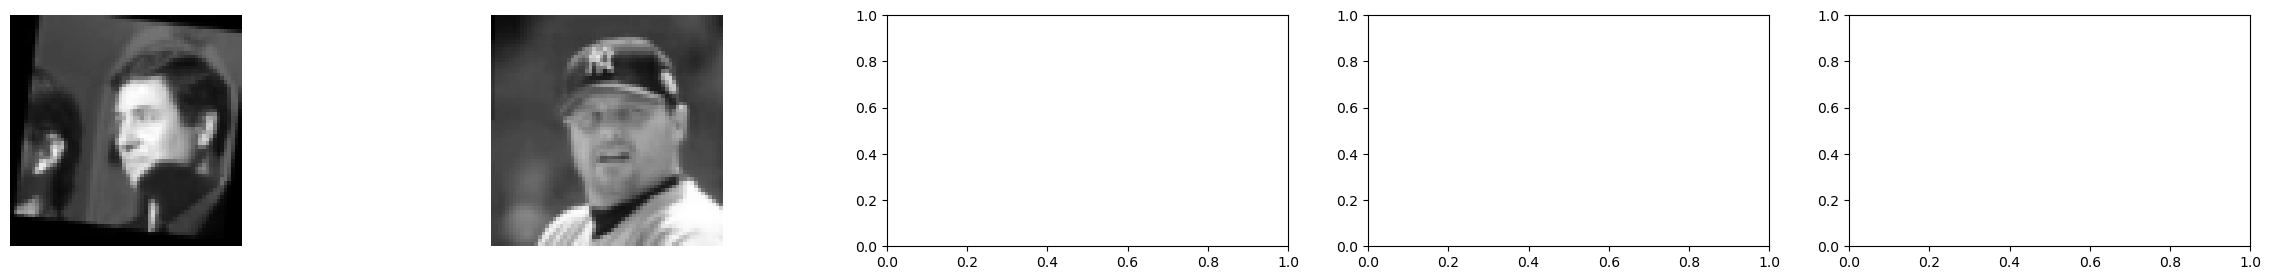

In [11]:
import matplotlib.pyplot as plt

SUBPLOT_COUNT = 5

fig_anchors, anchors = plt.subplots(1, SUBPLOT_COUNT, figsize=(30,3))
fig_pos, positives = plt.subplots(1, SUBPLOT_COUNT, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, SUBPLOT_COUNT, figsize=(30,3))
for i in range(SUBPLOT_COUNT):
    (anchor, positive, negative), _ = train_dataset[i]
    anchors[i].imshow(anchor[0], cmap="gray")
    anchors[i].axis("off")
    positives[i].imshow(positive[0], cmap="gray")
    positives[i].axis("off")
    negatives[i].imshow(negative[0], cmap="gray")
    negatives[i].axis("off")
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()
plt.show()

### TriNet Siamese model

### SimCLR model